# Image Segmentation

Mounted at /content/gdrive


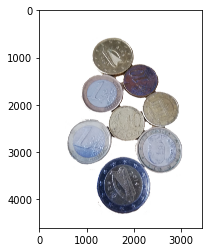

In [1]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
drive.mount('/content/gdrive', force_remount=True)

coinsimg = cv2.imread('/content/gdrive/My Drive/Colab Notebooks/Coins.jpg')
coinsimg = cv2.cvtColor(coinsimg, cv2.COLOR_BGR2RGB)
plt.imshow(coinsimg)

**Apply Blur**

There is too much detail in this image, including light, the face edges on the coins, and too much detail in the background. To reduce this we can use Median Blur Filtering to blur the image a bit, which will be useful later when we threshold.

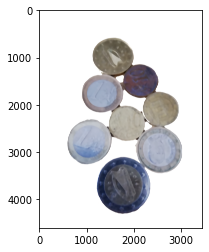

In [2]:
coins_blur = cv2.medianBlur(coinsimg,39)
plt.imshow(coins_blur)

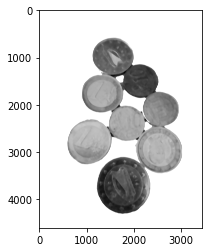

In [3]:
graycoins = cv2.cvtColor(coins_blur,cv2.COLOR_BGR2GRAY)
plt.imshow(graycoins, cmap='gray')

**Binary Threshold**

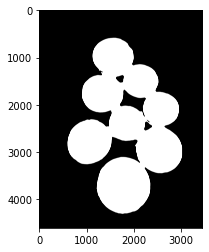

In [4]:
ret, coinsthresh = cv2.threshold(graycoins,220,255,cv2.THRESH_BINARY_INV)
plt.imshow(coinsthresh,cmap='gray')

**Find Contours**

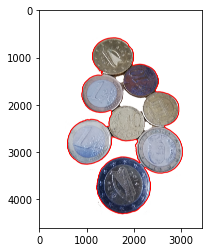

In [5]:
contours, hierarchy = cv2.findContours(coinsthresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# For every entry in contours
for i in range(len(contours)):
    
    # last column in the array is -1 if an external contour (no contours inside of it)
    if hierarchy[0][i][3] == -1:
        
        # We can now draw the external contours from the list of contours
        cv2.drawContours(coinsimg, contours, i, (255, 0, 0), 20)
plt.imshow(coinsimg,cmap='gray')

# Watershed Algorithm

**Otsu Threshold**

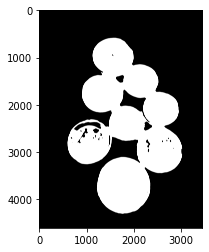

In [6]:
#Remove Noise
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(graycoins,cv2.MORPH_OPEN,kernel, iterations = 5)

ret, otsuthresh = cv2.threshold(graycoins,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(otsuthresh,cmap='gray')

**Isolate Background**

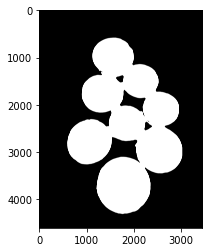

In [7]:
# sure background area
sure_bg = cv2.dilate(coinsthresh,kernel,iterations=3)
plt.imshow(sure_bg,cmap='gray')

**Isolate Foreground**

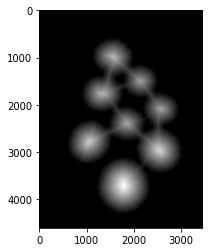

In [8]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(coinsthresh,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
plt.imshow(dist_transform,cmap='gray')

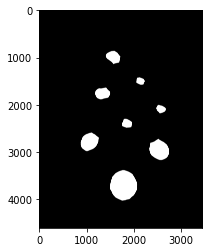

In [9]:
plt.imshow(sure_fg,cmap='gray')

**Unknown Region**

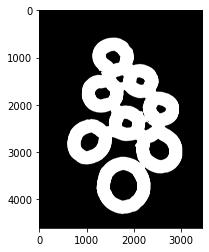

In [10]:
# Finding the unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown,cmap='gray')

**Mark Isolated Foreground**

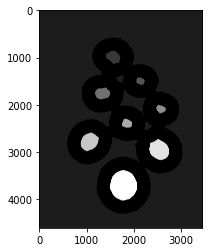

In [11]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
plt.imshow(markers,cmap='gray')

**Apply Watershed Algorithm**

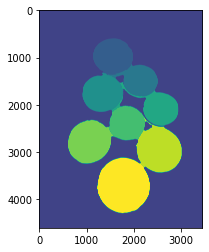

In [12]:
markers = cv2.watershed(coinsimg,markers)
plt.imshow(markers)

**Find Contours on Markers**

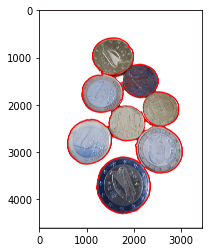

In [13]:
contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# For every entry in contours
for i in range(len(contours)):
    
    # last column in the array is -1 if an external contour (no contours inside of it)
    if hierarchy[0][i][3] == -1:
        
        # We can now draw the external contours from the list of contours
        cv2.drawContours(coinsimg, contours, i, (255, 0, 0), 10)
plt.imshow(coinsimg)